# Embeddings

In [1]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.models import Sequential

## Loading the data

In [2]:
with h5py.File('/data/joint_scoring/labels_test.h5', 'r') as hf:
    y = hf['labels_test'][:]
    
with h5py.File('/data/joint_scoring/img_test.h5', 'r') as hf:
    imgs = hf['img_test'][:]

imgs = imgs
y = y

y.shape, imgs.shape

((19611,), (19611, 150, 150, 1))

In [3]:
from tensorflow.python.keras.models import load_model

loaded_model = load_model("/data/joint_scoring/models/20171108_195245.h5")

In [4]:
pred = loaded_model.predict_classes(imgs)

19611/19611 [==============================] - 12s    


In [5]:
diff = pred - y

In [6]:
diff

array([ 0.,  0.,  3., ...,  1.,  2.,  0.])

## Build truncated model

In [7]:
config = loaded_model.get_config()

In [8]:
config = config[0:48]

In [9]:
model = Sequential.from_config(config)

In [10]:
weights = loaded_model.get_weights()

In [11]:
model.set_weights(weights)

## Get embeddings

In [12]:
embeddings = model.predict(imgs)

In [13]:
from sklearn.decomposition import PCA

x_50d = PCA(n_components=50).fit_transform(embeddings)

In [14]:
from sklearn.manifold import TSNE

x_2d = TSNE(n_components=2, random_state=1).fit_transform(x_50d)

## 2D

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(25,25))
plt.scatter(x_2d[:, 0], x_2d[:, 1], c=y, cmap=plt.cm.get_cmap("viridis", 6))
plt.colorbar()
plt.savefig('/data/joint_scoring/images/tsne_classification.png', bbox_inches='tight')

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(25,25))
plt.scatter(x_2d[:, 0], x_2d[:, 1], c=diff, cmap=plt.cm.get_cmap("RdBu", 10))
plt.colorbar()
plt.savefig('/data/joint_scoring/images/tsne_diference_classification.png', bbox_inches='tight')

## KNN

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [18]:
cv_scores = []

for k in range(1,10,2):
    print(k)
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, embeddings, y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

1
3
5
7
9


In [19]:
cv_scores

[0.61348894649781649,
 0.65545282117078174,
 0.67839829048465661,
 0.69048233671353254,
 0.69604213873637533]

The optimal number of neighbors is 9


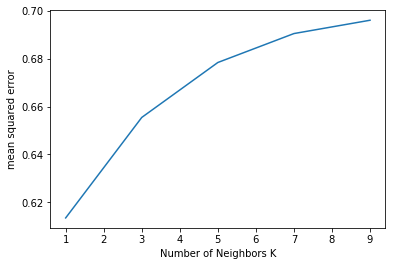

In [22]:
# determining best k
from matplotlib import pyplot as plt
optimal_k = range(1,10,2)[cv_scores.index(max(cv_scores))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.close()
plt.plot(range(1,10,2), cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('mean squared error')
plt.show()

In [25]:
from sklearn.model_selection import cross_val_predict
knn = KNeighborsClassifier(n_neighbors=9)
pred = cross_val_predict(estimator=knn, X=embeddings, y=y, cv=10)

Confusion matrix, without normalization
[[11800  1434    14     8     2    28]
 [ 3552  1696    50    17     9    45]
 [   94   242    39    14     6    28]
 [   29    80    32     8     6    22]
 [   15    37    15     8     3    20]
 [   35    77    15    15    12   104]]
Normalized confusion matrix
[[  8.88152943e-01   1.07933163e-01   1.05374078e-03   6.02137588e-04
    1.50534397e-04   2.10748156e-03]
 [  6.61575712e-01   3.15887502e-01   9.31272118e-03   3.16632520e-03
    1.67628981e-03   8.38144906e-03]
 [  2.22222222e-01   5.72104019e-01   9.21985816e-02   3.30969267e-02
    1.41843972e-02   6.61938534e-02]
 [  1.63841808e-01   4.51977401e-01   1.80790960e-01   4.51977401e-02
    3.38983051e-02   1.24293785e-01]
 [  1.53061224e-01   3.77551020e-01   1.53061224e-01   8.16326531e-02
    3.06122449e-02   2.04081633e-01]
 [  1.35658915e-01   2.98449612e-01   5.81395349e-02   5.81395349e-02
    4.65116279e-02   4.03100775e-01]]


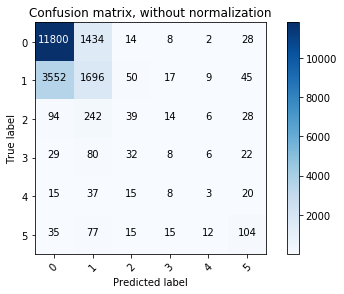

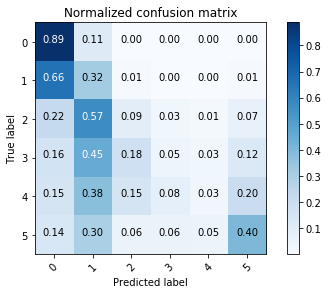

In [32]:
from sklearn.metrics import confusion_matrix
import itertools
cnf_matrix = confusion_matrix(y, pred)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(6),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(6), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [33]:
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("Mean accuracy per class")
print(np.mean(np.diag(cm)))

Mean accuracy per class
0.29585829784


In [34]:
upper = np.diag(cm, 1)
upper = np.append(upper, 0)
diagonal = np.diag(cm)
lower = np.diag(cm, -1)
lower = np.append(0, lower)

arr = np.vstack((upper, diagonal, lower))
print("Mean accuracy in the correct class or +- 1")
print(arr.sum(axis=0).mean())

Mean accuracy in the correct class or +- 1
0.617681251359


## 3D

In [17]:
from sklearn.manifold import TSNE
x_embedded = TSNE(n_components=3, random_state=1).fit_transform(x_50d)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(25,25))
ax = Axes3D(fig)
ax.scatter(x_embedded[:, 0], x_embedded[:, 1], x_embedded[:, 2], c=y, cmap=plt.cm.get_cmap("viridis", 6))
plt.savefig('/data/joint_scoring/images/tsne_3d_classification.png', bbox_inches='tight')

In [129]:
!pip3 install scikit-image --upgrade
from skimage.transform import resize
imgs_resized = [resize(image=x, output_shape=(50, 50)) for x in imgs]
imgs_resized = np.array(imgs_resized)

Requirement already up-to-date: scikit-image in /usr/local/lib/python3.5/dist-packages
Requirement already up-to-date: matplotlib>=1.3.1 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: scipy>=0.17.0 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: six>=1.7.3 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: PyWavelets>=0.4.0 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: pillow>=2.1.0 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: networkx>=1.8 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /usr/local/lib/python3.5/dist-packages (from matplotlib>=1.3.1->scikit-image)
Requirement already up-to-date: numpy>=1.7.1 in /usr/local/lib/python3.5/dist-packages (from matplotlib>=1

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [95]:
cm = plt.cm.get_cmap("viridis", 6)
color = np.ones((6, 4))
for i in range(6):
    color[i] = cm(1.*i/6)

#color = [x[0:-1] for x in color]
color = [np.append((x[0:-1] * 255),1) for x in color]
color = np.array(color)


color = color.astype("int16")

print(color)
print(type(color[0]))

[[ 68   1  84   1]
 [ 64  67 135   1]
 [ 41 120 142   1]
 [ 34 167 132   1]
 [121 209  81   1]
 [253 231  36   1]]
<class 'numpy.ndarray'>


In [96]:
tuple(color[0])

(68, 1, 84, 1)

In [117]:
y

62.845509

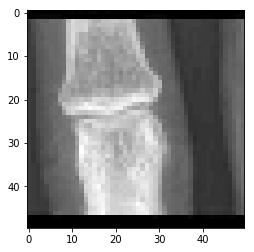

In [201]:
plt.imshow(imgs_resized[1].squeeze(), cmap="gray")
plt.show()

In [221]:
from PIL import Image
from PIL import ImageMath

imgs_border = []

old_size = (50, 50)
new_size = (54, 54)

for i, img in enumerate(imgs_resized):
    if i % 100 == 0:
        clear_output()
        print("Creating images with colored borders, {0:.2f} % finished".format(i/19611*100))
    old_im = Image.fromarray((img.squeeze()*255).astype("int16"))
    old_im = old_im.convert("RGB")
    new_im = Image.new("RGB", new_size, tuple(color[int(y[i])]))
    new_im.paste(old_im, (2,2))
    dat = np.asarray(a=new_im)
    imgs_border.append(dat)


Creating images with colored borders, 99.94 % finished


In [225]:
np.array(imgs_border).shape

(19611, 54, 54, 3)

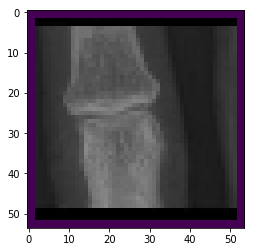

In [226]:
plt.imshow(imgs_border[1])
plt.show()

In [227]:
from IPython.display import clear_output
res = 8000 # resolution of plot
cval = 255 # background colour

images = imgs_border
max_width = max([image.shape[0] for image in images])
max_height = max([image.shape[1] for image in images])

In [228]:
f2d = x_2d

xx = f2d[:, 0]
yy = f2d[:, 1]
x_min, x_max = xx.min(), xx.max()
y_min, y_max = yy.min(), yy.max()
# Fix the ratios
sx = (x_max-x_min)
sy = (y_max-y_min)
if sx > sy:
    res_x = sx/float(sy)*res
    res_y = res
else:
    res_x = res
    res_y = sy/float(sx)*res

In [229]:
res_x, res_y

(8000, 8615.1535825786468)

In [230]:
res_y=res_y.astype("int16")

In [231]:
images[0].shape

(54, 54, 3)

In [232]:
canvas = np.ones((res_x+max_width, res_y+max_height, 3))*cval
x_coords = np.linspace(x_min, x_max, res_x)
y_coords = np.linspace(y_min, y_max, res_y)
i = 0
for x, y, image in zip(xx, yy, images):
    clear_output()
    print("Creating plot, {0:.2f} % finished".format(i/19611*100))
    i = i + 1
    w, h = image.shape[:2]
    x_idx = np.argmin((x - x_coords)**2)
    y_idx = np.argmin((y - y_coords)**2)
    canvas[x_idx:x_idx+w, y_idx:y_idx+h] = image

Creating plot, 99.99 % finished


In [ ]:
!rm /data/joint_scoring/images/embeddings_classification.png

In [234]:
plt.figure(figsize=(400,400))
plt.imshow(canvas)
plt.savefig('/data/joint_scoring/images/embeddings_classification.png', bbox_inches='tight')